## <center><h1> TP 3 </br> Modèles probabilistes génératifs pour le Machine Learning </center></h1>

In [1]:
# imports and constants ...
import numpy as np
import math
import matplotlib.pyplot as plt
from TP3_functions.load_ag_news import load_ag_news
from TP3_functions.load_conll2000 import load_conll2000

path = "TP3_functions/"
train_set, test_set = load_ag_news(path)

## 1 - Exercice 1 : Classification de texte avec le modèle Naive Bayes

### 1.2 - Développer un Naive Bayes !

Estimation des paramètres sur le corpus d’entraînement par maximum de vraisemblance,donc en comptant les différents patterns.

In [2]:
def estim_param_bayes(train_set,label):                                                                                                                                                                            
    Pi = {}                                                                                                                                                                                                        
    B  = {}                                                                                                                                                                                                        
                                                                                                                                                                                                                   
    sum_total = 0                                                                                                                                                                                                  
    for label, text in train_set:                                                                                                                                                                                  
        if label not in B.keys():                                                                                                                                                                                  
            B[label] = {}                                                                                                                                                                                          
            Pi[label] = 0                                                                                                                                                                                          
                                                                                                                                                                                                                   
        for word in text:                                                                                                                                                                                          
            if word not in B[label]:                                                                                                                                                                               
                B[label][word] = 0                                                                                                                                                                                 
            B[label][word] += 1                                                                                                                                                                                    
                                                                                                                                                                                                                   
        Pi[label] += 1                                                                                                                                                                                             
        sum_total +=1                                                                                                                                                                                              
                                                                                                                                                                                                                   
    for label in  Pi.keys():                                                                                                                                                                                       
        Pi[label] /= sum_total                                                                                                                                                                                     
                                                                                                                                                                                                                   
    for label in  B.keys():                                                                                                                                                                                        
        sum_label = sum(B[label].values())                                                                                                                                                                         
        for word in B[label]:                                                                                                                                                                                      
            B[label][word] /= sum_label                                                                                                                                                                            
            sum_total += sum_label                                                                                                                                                                                 
                                                                                                                                                                                                                   
    return Pi, B 

In [3]:
Pi, B = estim_param_bayes(train_set,'London')

In [4]:
print(f'La valeu de Pi[1] = {Pi[1]}')
print(f'B[1][\'London\'] = {B[1]["London"]}')

La valeu de Pi[1] = 0.25
B[1]['London'] = 0.00018036294574312617


### Codage du modèle Naive Bayes.

In [5]:
def naive_bayes_model(sentence, Pi, B, epsilon, classes):
    bayes_coeff = {}
    for _cls in classes :
        coeff = Pi[_cls]
        for word in sentence :
            coeff *= B[_cls].get(word, 0) + epsilon
        bayes_coeff[_cls] = coeff

    _sum_prob_cls = sum(bayes_coeff.values())
    for _cls in classes :
        bayes_coeff[_cls] /= _sum_prob_cls
    return bayes_coeff

def naive_bayes_model_log(sentence, Pi, B, epsilon, classes):
    bayes_coeff = {}
    for _cls in classes :
        coeff = np.log(Pi[_cls])
        for word in sentence :
            coeff += np.log(B[_cls].get(word, 0) + epsilon)
        bayes_coeff[_cls] = coeff
   
    return bayes_coeff

def calc_error_predict(sentence, Pi, B, epsilon, classes):
    pred_score = 0
    for label, text in sentence:
        proba = naive_bayes_model_log(text, Pi, B, epsilon, classes)
        label_predicted = max(proba, key=proba.get)
        if label == label_predicted:
            pred_score += 1
    return pred_score / len(sentence)

###  Prédiction pour la phrase y1∶6 =["Arsenal", "is", "a", "londonian", "team", "."], avec affichage des différentes probabilités pour chaque classe, en prenant ε = 0.00001 (le paramètre de lissage)

In [6]:
sentence_test = ["Arsenal", "is", "a", "londonian", "team", "."]
epsilon = 10**-5
classes = [0,1,2,3]
predict_prob = naive_bayes_model(sentence_test, Pi, B, epsilon, classes)
print(f'Pour Epsilon = {epsilon}, \t on obtient le resultat de prédiction {predict_prob[1]}')
print(naive_bayes_model_log(sentence_test, Pi, B, epsilon, classes))

Pour Epsilon = 1e-05, 	 on obtient le resultat de prédiction 0.9924989725858532
{0: -45.470738372956355, 1: -39.61001746015084, 2: -46.80485677037962, 3: -45.142013560135496}


### Prédiction sur l’ensemble du corpus de test, vous indiquerai le pourcentage de textes correctement prédits. Vous ferez ces prédictions trois fois en prenant ε dans {10−10 , 10−5 , 1}

In [7]:
epsilon_lst = [10**-10, 10**-5, 1]
for epsi in epsilon_lst:
    res = calc_error_predict(test_set, Pi, B, epsi, classes)
    print(f'Pour Epsilon = {epsi}, \t on obtient le resultat de prédiction {res}')

Pour Epsilon = 1e-10, 	 on obtient le resultat de prédiction 0.9010526315789473
Pour Epsilon = 1e-05, 	 on obtient le resultat de prédiction 0.8940789473684211
Pour Epsilon = 1, 	 on obtient le resultat de prédiction 0.4909210526315789


On remarque que plus epsilon est petit, plus le taux d'erreur esr elevé 

## 2 - Exercice 2 : Étiquetage morpho-syntaxique avec une chaîne de Markov cachée

In [8]:
train_set, test_set = load_conll2000(path)

In [9]:
def calc_pi(data_set):
    pi = {}
    len_counter = 0
    for item in data_set:
        for label, word in item:
            if label not in pi.keys() :
                pi[label] = 1
            else:
                pi[label] += 1
            len_counter += 1
    for item in pi:
        pi[item] /= len_counter
    return pi

pi = calc_pi(train_set)
pi['ADJ']

0.06759648037331091

In [10]:
def calc_a(data_set):
    a = {}
    words_nbr = 0
    for item in data_set:                                                                                                                                                                                     
        for index in range(len(item)-1):                                                                                                                                                                           
            word = item[index][0]                                                                                                                                                                                 
            next_word = item[index+1][0]                                                                                                                                                                               
            if word not in a.keys():                                                                                                                                                                                
                a[word] = {}                                                                                                                                                                                        
            if next_word not in a[word]:                                                                                                                                                                                
                a[word][next_word] = 1                                                                                                                                                                                  
            else :                                                                                                                                                                                                 
                a[word][next_word] += 1                                                                                                                                                                                 
                                                                                                                                                                                                                   
    for word in a.keys():                                                                                                                                                                                           
        words_nbr = sum(a[word].values())                                                                                                                                                                             
        for next_word in a[word]:                                                                                                                                                                                       
            a[word][next_word] /= words_nbr 
    return a

a = calc_a(train_set)
a['NUM']['NOUN']

0.34821321140656963

In [11]:
def calc_b(data_set):
    b = {}
    label_nbr = 0
    for item in data_set:                                                                                                                                                                                     
        for label, word in item:                                                                                                                                                                               
            if label not in b.keys():                                                                                                                                                                              
                b[label] = {}                                                                                                                                                                                      
            if word not in b[label]:                                                                                                                                                                               
                b[label][word] = 0                                                                                                                                                                                 
            b[label][word] +=1                                                                                                                                                                                     
                                                                                                                                                                                                                   
    for label in b.keys():                                                                                                                                                                                         
        label_nbr = sum(b[label].values())                                                                                                                                                                         
        for word in b[label]:                                                                                                                                                                                      
            b[label][word] /=  label_nbr  
            
    return b

b = calc_b(train_set)
b['PUNCT']['.']

0.36019485612847296

### Codage de l’algorithme Foward-Backward.

In [12]:
def calc_alpha(sentence, pi, epsilon, a, b):
    alpha = {}
    for label in pi.keys():
        alpha[label]    = [0] * len(sentence)
        alpha[label][0] = pi[label] * b[label].get(sentence[0], epsilon)

    for index_i in range(len(sentence) - 1):
        for label in pi.keys():
            index_j = index_i + 1
            alpha[label][index_j] = b[label].get(sentence[index_j], epsilon) * \
            sum([alpha[index_y][index_i]*a[index_y].get(label,epsilon) for index_y in pi.keys()])
    return alpha
            
def calc_beta(sentence, pi, epsilon, a, b):
    beta = {}
    for label in pi.keys():
        beta[label]    = [0] * len(sentence)
        beta[label][-1] = 1

    for index_i in range(len(sentence) - 2, -1, -1):
        for label in pi.keys():
            index_j = index_i + 1
            beta[label][index_i] = sum([beta[index_y][index_j]*a[label].get(index_j,epsilon)*b[index_y].get(sentence[index_j],epsilon) for index_y in pi.keys()])
    return beta
            
def calc_gama(alpha, beta, pi, len_sentence):
    gamma = {}
    label_pred = [''] * len_sentence
    for label in pi.keys():
        gamma[label] = list(map(lambda x, y: x*y, alpha[label], beta[label]))

    for i in range(len_sentence):
        label_pred[i] = max(gamma, key=lambda x: gamma[x][i])
    return label_pred


def forward_backward(pi, a, b, epsilon, sentence):
    alpha = calc_alpha(sentence, pi, epsilon, a, b)
    beta = calc_beta(sentence, pi, epsilon, a, b)
    return calc_gama(alpha, beta, pi, len(sentence))

In [13]:
sentence = ["I", "am", "a", "student", "in", "a", "French", "school", "."]
epsilon = 10**-5
label_pred = forward_backward(pi, a, b, epsilon, sentence)
print(f'Phrase :\t\t {sentence}')
print(f'Labels predits : \t {label_pred}')

Phrase :		 ['I', 'am', 'a', 'student', 'in', 'a', 'French', 'school', '.']
Labels predits : 	 ['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


In [14]:
def calc_error_predict_for_data_set(pi, a, b, epsilon, data_set):
    labels = []
    words = []
    words_nbr = 0
    score = 0

    for element in data_set:
        for item in element:
            labels.append(item[0])
            words.append(item[1])

        labels_pred = forward_backward(pi, a, b, epsilon, words)                                                                                                                                        

        words_nbr += len(words)
        score += sum(list(map(lambda p, t: p == t, labels_pred, labels)))

    score /= words_nbr
    return score

In [15]:
err_predection = calc_error_predict_for_data_set(pi, a, b, epsilon, test_set)

In [24]:
print(f'Le score final pour tout le corpus est de {err_predectionection}')

Le score final pour tout le corpus est de 0.20345358487344747


## 3 - Exercice 3 : Filtrage de Kalman

In [16]:
X = np.loadtxt(path + "signal_X.txt")
Y = np.loadtxt(path + "signal_Y.txt")

### Estimation de la valeur des paramètres a et b de manière non supervisée.


In [17]:
def kalman_param_estim(Y):
    ab2 = (Y[:-1] * Y[1:]).mean()
    a2b2 = (Y[:-2] * Y[2:]).mean()
    
    a = a2b2/ab2
    b = np.sqrt(ab2 / a)
    
    return a, b

a, b = kalman_param_estim(Y)
print(f'Les paramètres estimés de Kalman sont : \n\
\t - a = {a} \n \t - b = {b}')

Les paramètres estimés de Kalman sont : 
	 - a = 0.5966338342965285 
 	 - b = 0.8860784695470194


### Codage du filtre de Kalman afin de restaurer le signal

In [35]:
def kalman_filter(Y, a, b):
    pred_val = [b * Y[0]]
    sigma = [1 - np.power(b,2)]
    
    for index in range(len(Y) - 1):
        # prediction
        x_tmp = a * pred_val[-1]
        sig_tmp = 1 - np.power(a,2) + (np.power(a,2) * sigma[-1])
        
        # update
        y_tmp = Y[index+1] - (b*x_tmp)
        next_S = 1 - np.power(b,2) + (np.power(b,2) * sig_tmp)
        next_K = (sig_tmp*b)/next_S
        
        next_X = x_tmp + next_K * y_tmp
        next_sigma = (1 - (b * next_K)) * sig_tmp
        
        pred_val.append(next_X)
        sigma.append(next_sigma)
    
    return np.array(pred_val)

In [33]:
def calc_mse(val_1, val_2):
    return (np.power((val_1 - val_2), 2)).mean()

In [36]:
x_restored = kalman_filter(Y, a, b)
x_restored

array([ 0.04619194,  2.12182635,  1.05618188, ...,  0.69804339,
        0.1360445 , -0.56867387])

In [37]:
err_mse = calc_mse(X, x_restored)
print(f'L\'erreur quadratique entre X et X_restored est {err_mse}')

L'erreur quadratique entre X et X_restored est 0.1744952107401793


In [38]:
err_mse = calc_mse(X, Y)
print(f'L\'erreur quadratique entre X et Y est {err_mse}')

L'erreur quadratique entre X et Y est 0.20225719834189368


Nous remarquons que l'erreur quadratique moyenne entre le signal d'origine et le signale reconstitué est inférieure à l'erreur quadratique moyenne entre le signal d'origine est le signal bruité

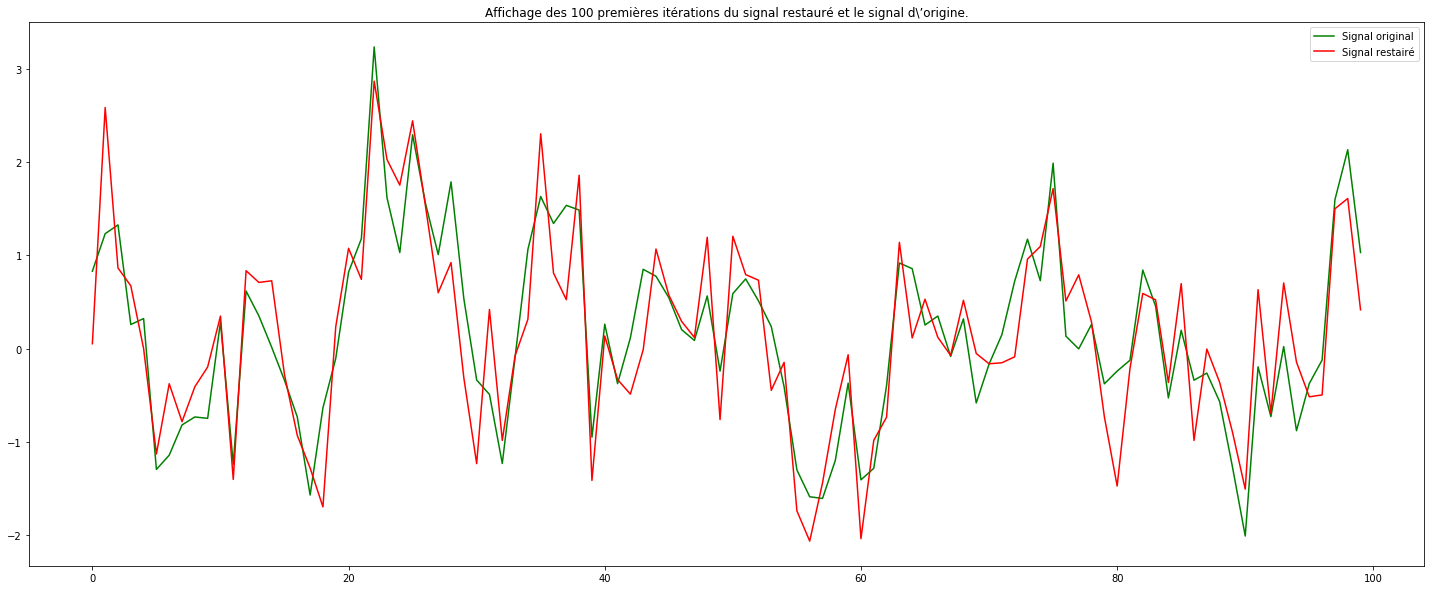

In [39]:
plt.figure(figsize=(25,10))
plt.plot(X[:100], c='green', label='Signal original')
plt.plot(Y[:100], c='r', label='Signal restairé')
plt.title('Affichage des 100 premières itérations du signal restauré et le signal d\’origine.')
plt.legend()
plt.show()